In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
nu = notebookUtils()
model_name = "strawmaker"

In [3]:
dataset, features, indicators = nu.loadData(indicators=[('bop', 'close'),('optimal_v2', 'close')],
                            param_spec={},
                            optimal_threshold={'buy':0.8},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10,30,60]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2,3,5,10,30]},
                                    {'indicator_name':'natr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [30,60,120,180]},
                                    {'indicator_name':'cmo',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2,3,5,10,60]}
                                    
                                    ],

                            scale='minmaxwindow')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTCUSDT-1m...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from chunk 5...
Loading data from chunk 6...
Loading data from chunk 7...
Loading data from chunk 8...
Loading data from chunk 9...
Loading data from chunk 10...


In [4]:
dataset.drop(["time", "open", "high", "low", "volume"], axis=1, inplace=True)
dataset.dropna(inplace=True)
dataset

,close,BOP,optimal,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_10,CCI_close_period_30,CCI_close_period_60,RSI_close_period_2,RSI_close_period_3,...,RSI_close_period_30,NATR_close_period_30,NATR_close_period_60,NATR_close_period_120,NATR_close_period_180,CMO_close_period_2,CMO_close_period_3,CMO_close_period_5,CMO_close_period_10,CMO_close_period_60
15179,3499.451907,1.000000,0.0,0.597535,0.008918,0.401253,0.441369,0.634824,0.061887,0.028527,...,0.316863,0.130093,0.144570,0.149913,0.161489,0.061887,0.028527,0.058300,0.176657,0.406218
15180,3499.480953,0.500000,0.0,0.597687,0.009518,0.417499,0.445325,0.638129,0.116448,0.045183,...,0.317142,0.125280,0.141351,0.147881,0.159940,0.116448,0.045183,0.063827,0.178057,0.406367
15181,3499.495477,0.500000,0.0,0.597763,0.009818,0.429495,0.445433,0.640944,0.165011,0.057304,...,0.317287,0.120607,0.138174,0.145859,0.158394,0.165011,0.057304,0.067249,0.178833,0.406443
15182,3501.247738,0.000000,0.0,0.622832,0.045999,0.614453,0.465052,0.655268,0.941458,0.714128,...,0.334926,0.123457,0.139544,0.146578,0.158870,0.941458,0.714128,0.398706,0.271062,0.415660
15183,3502.123869,0.500000,0.0,0.633669,0.064090,0.607448,0.460668,0.652634,0.969665,0.812243,...,0.343744,0.120034,0.137105,0.144975,0.157616,0.969665,0.812243,0.507982,0.313886,0.420276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483226,18519.207620,0.760555,0.0,0.126793,0.031906,0.374346,0.457764,0.481224,0.338749,0.206272,...,0.347502,0.034011,0.037195,0.041808,0.039089,0.338749,0.206272,0.140345,0.188305,0.440843
1483227,18523.983810,0.590570,0.0,0.221838,0.088531,0.588887,0.498162,0.515173,0.806718,0.597023,...,0.371308,0.040823,0.041509,0.044551,0.041156,0.806718,0.597023,0.372281,0.280479,0.452645
1483228,18525.301905,0.323209,0.0,0.252022,0.102116,0.516987,0.488539,0.495990,0.861009,0.665257,...,0.377846,0.037662,0.039408,0.043077,0.039954,0.861009,0.665257,0.425864,0.304817,0.455897
1483229,18526.950952,0.603018,0.0,0.289785,0.119112,0.525494,0.492946,0.490491,0.918377,0.745989,...,0.386144,0.035375,0.037842,0.041945,0.039014,0.918377,0.745989,0.493587,0.336128,0.459998


In [46]:
trainX, testX, trainy, testy = nu.splitData(dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':4, 'superset_class_val':0, 'randomize_concat':True})
trainX

,close,BOP,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_10,CCI_close_period_30,CCI_close_period_60,RSI_close_period_2,RSI_close_period_3,RSI_close_period_5,...,RSI_close_period_30,NATR_close_period_30,NATR_close_period_60,NATR_close_period_120,NATR_close_period_180,CMO_close_period_2,CMO_close_period_3,CMO_close_period_5,CMO_close_period_10,CMO_close_period_60
0,7491.858377,0.454220,0.332382,0.607771,0.428000,0.488980,0.488983,0.104812,0.195418,0.342900,...,0.508541,0.418541,0.666216,0.829831,0.894027,0.104812,0.195418,0.342900,0.476110,0.533056
1,8652.392982,0.465217,0.535637,0.294300,0.424067,0.515981,0.586207,0.092040,0.202811,0.301671,...,0.455406,0.045024,0.071343,0.082430,0.091217,0.092040,0.202811,0.301671,0.370854,0.494614
2,6628.263415,0.506598,0.840195,0.588689,0.623836,0.517298,0.542019,0.961806,0.860223,0.702465,...,0.457309,0.169217,0.211744,0.245707,0.252911,0.961806,0.860223,0.702465,0.554061,0.399456
3,4206.636881,0.500000,0.632380,0.705949,0.599586,0.460110,0.516885,0.907959,0.803244,0.734058,...,0.618472,0.357402,0.353974,0.347037,0.350120,0.907959,0.803244,0.734058,0.698587,0.567982
4,6189.617524,0.602067,0.607820,0.518090,0.494146,0.429836,0.406891,0.157173,0.374779,0.538873,...,0.518428,0.079598,0.104344,0.123849,0.133781,0.157173,0.374779,0.538873,0.551816,0.515234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195205,5349.648102,0.303947,0.016612,0.219808,0.401234,0.504740,0.484725,0.002315,0.024048,0.105900,...,0.432160,0.144743,0.209180,0.290106,0.372699,0.002315,0.024048,0.105900,0.279024,0.449957
195206,6399.755558,0.062500,0.233655,0.529725,0.397054,0.463748,0.431771,0.152097,0.196201,0.317181,...,0.553267,0.062387,0.065751,0.101747,0.132101,0.152097,0.196201,0.317181,0.476292,0.537046
195207,11439.731943,0.760224,0.782426,0.953726,0.614988,0.579312,0.512004,0.633326,0.675441,0.733391,...,0.603375,0.420063,0.589009,0.720732,0.780372,0.633326,0.675441,0.733391,0.766988,0.437652
195208,9379.828031,0.415833,0.586111,0.690441,0.577509,0.620502,0.577980,0.377769,0.523972,0.602023,...,0.588514,0.247849,0.283656,0.353610,0.430764,0.377769,0.523972,0.602023,0.638210,0.600324


In [47]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.625, 1: 2.5}

In [48]:
clf = XGBClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=2)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf.score(testX.drop("close", axis=1).values, testy.values))

# feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

# for i in range(len(feature_importances.importances_mean)):
#     print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

[18:38:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { class_weight, criterion, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9017689174471049


In [51]:
reduced_classified_data = nu.classifyPoints(clf, testX, predict_proba=True, proba_thresh=0.6, plot_optimal=True, optimal=testy)

In [52]:
smaller_view_data = reduced_classified_data[800:1800]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

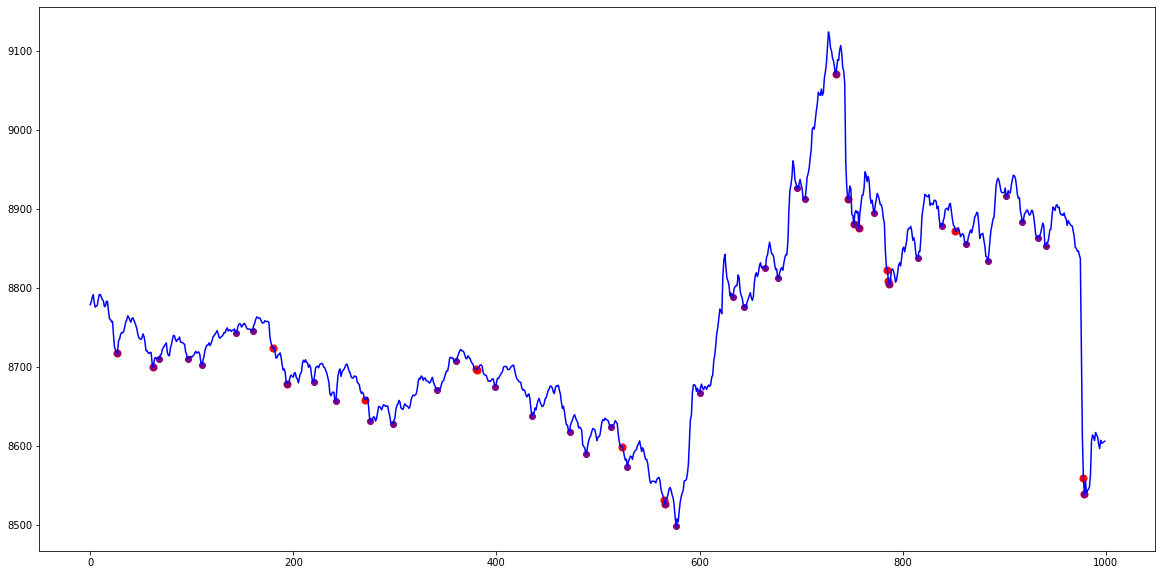

In [53]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=True)

In [15]:
# model_version = nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.75, is_nn=False)

In [16]:
# score, trades = nu.testModel(model_name)

In [17]:
# updateScoreboard(model_name, model_version, score, trades, features)